In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

In [3]:
tf.executing_eagerly()

True

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

2.0.0-alpha0


In [5]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', extract=True)

In [69]:
print(path_to_zip)
path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

/Users/olegbrusilovski/.keras/datasets/spa-eng.zip


In [7]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

In [8]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
    

In [9]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    return  word_pairs

In [10]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(" "))
        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0

        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [11]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
def load_dataset(path, num_examples):
    pairs = create_dataset(path, num_examples)
    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(" ")] for en, sp in pairs]

    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(" ")] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_targ = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_targ, padding='post')
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ

In [77]:
num_examples = 100000

In [78]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [79]:
input_tensor[0]

array([    5, 24107,     3,     4,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [80]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [81]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(95171, 95171, 23793, 23793)

In [18]:
BUFFER_SIZE = len(input_tensor_train)

In [19]:
BATCH_SIZE = 64

In [20]:
N_BATCH = BUFFER_SIZE // BATCH_SIZE

In [21]:
print(N_BATCH)

375


In [22]:
embedding_dim = 256

In [23]:
units = 1024

In [24]:
vocab_inp_size = len(inp_lang.word2idx)+1
vocab_tar_size = len(targ_lang.word2idx)+1
print(vocab_inp_size, vocab_tar_size)

9415 4936


In [25]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

In [26]:
dataset

<ShuffleDataset shapes: ((16,), (11,)), types: (tf.int32, tf.int32)>

In [27]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [28]:
dataset

<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>

In [29]:
# We're using Bahdanau attention. Lets decide on notation before writing the simplified form:

# FC = Fully connected (dense) layer
# EO = Encoder output
# H = hidden state
# X = input to the decoder
# And the pseudo-code:

# score = FC(tanh(FC(EO) + FC(H)))
# attention weights = softmax(score, axis = 1). Softmax by default is applied on the last axis but here we want to apply
# it on the 1st axis, since the shape of score is (batch_size, max_length, 1). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
# context vector = sum(attention weights * EO, axis = 1). Same reason as above for choosing axis as 1.
# embedding output = The input to the decoder X is passed through an embedding layer.
# merged vector = concat(embedding output, context vector)
# This merged vector is then given to the GRU

In [30]:
def gru(units):
    return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, 
                               recurrent_initializer='glorot_uniform')

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state  = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super().__init__()
        self.batch_sz  =  batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [33]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [34]:
example_input_batch, example_target_batch = next(iter(dataset))
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [35]:
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [36]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [37]:
optimizer = tf.compat.v1.train.AdamOptimizer()

In [38]:
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [39]:
checkpoint_dir = './training_checkpoints'

In [40]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [41]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [42]:
# 1.Pass the input through the encoder which return encoder output and the encoder hidden state.
# 2.The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
# 3.The decoder returns the predictions and the decoder hidden state.
# 4.The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
# 5.Use teacher forcing to decide the next input to the decoder.
# 6.Teacher forcing is the technique where the target word is passed as the next input to the decoder.
# 7.The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [43]:
target_tensor

array([[   5, 1857,    3, ...,    0,    0,    0],
       [   5, 1857,    3, ...,    0,    0,    0],
       [   5, 1857,    3, ...,    0,    0,    0],
       ...,
       [   5, 4760, 2555, ...,    0,    0,    0],
       [   5, 4760, 2555, ...,    0,    0,    0],
       [   5, 4760, 2555, ...,    0,    0,    0]], dtype=int32)

In [44]:
input_tensor

array([[   5, 9090,    3, ...,    0,    0,    0],
       [   5, 9204,    3, ...,    0,    0,    0],
       [   5, 9082,    3, ...,    0,    0,    0],
       ...,
       [   5, 5498, 6764, ...,    0,    0,    0],
       [   5, 6228, 3454, ...,    0,    0,    0],
       [   5, 8600, 9184, ...,    0,    0,    0]], dtype=int32)

In [45]:
dataset

<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>

In [46]:
target_tensor.shape

(30000, 11)

In [47]:
input_tensor.shape

(30000, 16)

In [48]:
targ_lang.word2idx['<start>']

5

In [49]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t] ,predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6272
Epoch 1 Batch 100 Loss 2.0286
Epoch 1 Batch 200 Loss 1.8551
Epoch 1 Batch 300 Loss 1.7520
Epoch 1 Loss 2.0705
Time taken for 1 epoch 604.2985301017761 sec

Epoch 2 Batch 0 Loss 1.7190
Epoch 2 Batch 100 Loss 1.4534
Epoch 2 Batch 200 Loss 1.4463
Epoch 2 Batch 300 Loss 1.3797
Epoch 2 Loss 1.4951
Time taken for 1 epoch 613.4460883140564 sec

Epoch 3 Batch 0 Loss 1.3666
Epoch 3 Batch 100 Loss 1.1136
Epoch 3 Batch 200 Loss 1.1388
Epoch 3 Batch 300 Loss 0.9926
Epoch 3 Loss 1.1394
Time taken for 1 epoch 618.4113059043884 sec

Epoch 4 Batch 0 Loss 0.9930
Epoch 4 Batch 100 Loss 0.7832
Epoch 4 Batch 200 Loss 0.7893
Epoch 4 Batch 300 Loss 0.7083
Epoch 4 Loss 0.8100
Time taken for 1 epoch 632.605140209198 sec

Epoch 5 Batch 0 Loss 0.6823
Epoch 5 Batch 100 Loss 0.5741
Epoch 5 Batch 200 Loss 0.5591
Epoch 5 Batch 300 Loss 0.5036
Epoch 5 Loss 0.5637
Time taken for 1 epoch 632.4494869709015 sec

Epoch 6 Batch 0 Loss 0.4837
Epoch 6 Batch 100 Loss 0.4213
Epoch 6 Batch 200 Loss 

In [58]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word2idx[i] for i in sentence.split(" ")]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding="post")
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['start']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.idx2word[predicted_id] + " "
        
        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [52]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [53]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> voy a ir al cine esta noche . <end>
Predicted translation: i often tonight . <end> 


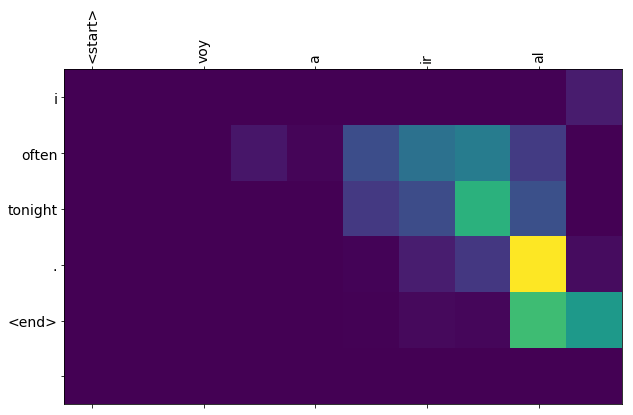

In [68]:
translate(u'voy a ir al cine esta noche.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)